# Phase 3: Parameter Sensitivity Analysis

## Multi-Car Racing Dynamics Simulation

This notebook analyzes how varying critical input parameters affects the primary outcome variables in the racing simulation.

### Parameters Selected for Analysis:
1. **Speed Multiplier** - Global speed scaling factor
2. **Strategy Distribution** - Ratio of aggressive to cautious drivers

### Primary Outcome Variables:
- Total Collisions
- Average Lap Times
- Number of Eliminated Cars
- Safety-Speed Tradeoff Index


## 1. Setup and Imports


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os
import sys
from datetime import datetime
import json

# Automatically change to racing_simulation directory if needed
current_dir = os.getcwd()
notebook_name = 'phase3.ipynb'

# Check if we're in the right directory
if os.path.basename(current_dir) != 'racing_simulation':
    # Try to find racing_simulation directory
    if os.path.exists(os.path.join(current_dir, 'racing_simulation')):
        os.chdir(os.path.join(current_dir, 'racing_simulation'))
        print(f"Changed directory to: {os.getcwd()}")
    elif os.path.exists(os.path.join(current_dir, '..', 'racing_simulation')):
        os.chdir(os.path.join(current_dir, '..', 'racing_simulation'))
        print(f"Changed directory to: {os.getcwd()}")
    elif notebook_name in os.listdir(current_dir):
        # We're already in racing_simulation
        pass
    else:
        print(f"Warning: Could not find racing_simulation directory.")
        print(f"Current directory: {current_dir}")
        print("Please run this notebook from the racing_simulation directory or update the path below:")
        print("# os.chdir('path/to/racing_simulation')")

# Add current directory to path
current_dir = os.getcwd()
sys.path.insert(0, current_dir)

print(f"Working directory: {current_dir}")
print(f"Config file should be at: {os.path.join(current_dir, 'config', 'parameters.yaml')}")

from simulation.simulation import RacingSimulation
from analysis.plot_results import plot_results
from analysis.heatmap import plot_collision_heatmap

# Set style for better plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        print("Using default matplotlib style")

%matplotlib inline


Working directory: c:\Users\apand\OneDrive\Desktop\Computational Models\Final Project\racing_simulation
Config file should be at: c:\Users\apand\OneDrive\Desktop\Computational Models\Final Project\racing_simulation\config\parameters.yaml


## 2. Load Base Configuration


In [4]:
def load_config(config_path='config/parameters.yaml'):
    """Load configuration from YAML file."""
    if not os.path.isabs(config_path):
        # Get current working directory
        project_root = os.getcwd()
        full_path = os.path.join(project_root, config_path)
        config_path = full_path
    
    if not os.path.exists(config_path):
        raise FileNotFoundError(
            f"Configuration file not found: {config_path}\n"
            f"Current working directory: {os.getcwd()}\n"
            f"Please ensure you're running the notebook from the racing_simulation directory.\n"
            f"You can change directory with: os.chdir('path/to/racing_simulation')"
        )
    
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load base configuration
base_config = load_config('config/parameters.yaml')
print("✓ Base configuration loaded successfully")
print(f"  Config file: {os.path.abspath('config/parameters.yaml')}")
print(f"  Number of cars: {base_config['num_cars']}")
print(f"  Target laps: {base_config['simulation']['laps']}")


✓ Base configuration loaded successfully
  Config file: c:\Users\apand\OneDrive\Desktop\Computational Models\Final Project\racing_simulation\config\parameters.yaml
  Number of cars: 10
  Target laps: 3


## 3. Parameter Variation: Speed Multiplier

**Why this parameter?** Speed is a critical factor in racing safety. Higher speeds typically lead to:
- Reduced reaction time
- Increased collision severity
- Shorter lap times (performance)
- Higher risk of accidents

We'll test speed multipliers from 0.7 to 1.5 to see the safety-speed tradeoff.


In [5]:
def run_simulation_with_params(config, speed_multiplier, visualize=False):
    """Run a single simulation with given parameters."""
    simulation = RacingSimulation(config, speed_multiplier=speed_multiplier, visualize=visualize)
    results = simulation.run()
    return results

# Test different speed multipliers
speed_multipliers = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
speed_results = []

print("Running simulations with varying speed multipliers...")
print("="*60)

for speed_mult in speed_multipliers:
    print(f"\nTesting speed multiplier: {speed_mult}")
    try:
        results = run_simulation_with_params(base_config, speed_mult, visualize=False)
        
        # Calculate average lap time
        all_lap_times = []
        for lap_times in results['lap_times'].values():
            all_lap_times.extend(lap_times)
        avg_lap_time = np.mean(all_lap_times) if all_lap_times else 0.0
        
        # Calculate average speed
        avg_speed = np.mean(list(results['average_speeds'].values())) if results['average_speeds'] else 0.0
        
        speed_results.append({
            'speed_multiplier': speed_mult,
            'total_collisions': results['total_collisions'],
            'near_misses': results['near_misses'],
            'eliminated_cars': results.get('num_eliminated', 0),
            'avg_lap_time': avg_lap_time,
            'avg_speed': avg_speed,
            'simulation_time': results['simulation_time'],
            'risk_index': results['total_collisions'] + results['near_misses'] * 0.1
        })
        print(f"  Collisions: {results['total_collisions']}, Avg Lap Time: {avg_lap_time:.2f}s")
    except Exception as e:
        print(f"  Error: {e}")
        continue

print("\n" + "="*60)
print("Speed multiplier analysis complete!")


Running simulations with varying speed multipliers...

Testing speed multiplier: 0.7
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   4%|▍         | 244/6000 [00:01<00:37, 154.85it/s]

Car 1 eliminated: Rolled 4 (threshold: <6)
Car 5 eliminated: Rolled 4 (threshold: <6)


Simulating:   5%|▌         | 317/6000 [00:02<00:31, 179.87it/s]

Car 4 eliminated: Rolled 3 (threshold: <6)
Car 6 eliminated: Rolled 4 (threshold: <6)


Simulating:   7%|▋         | 434/6000 [00:02<00:24, 225.22it/s]

Car 2 eliminated: Rolled 2 (threshold: <6)
Car 8 eliminated: Rolled 1 (threshold: <6)


Simulating:   8%|▊         | 489/6000 [00:02<00:22, 248.33it/s]

Car 7 eliminated: Rolled 1 (threshold: <6)


Simulating:  47%|████▋     | 2836/6000 [00:11<00:12, 257.66it/s]



All active cars completed 3 laps at t=141.80s
  Collisions: 4, Avg Lap Time: 32.97s

Testing speed multiplier: 0.8
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   4%|▍         | 246/6000 [00:01<00:28, 203.16it/s]

Car 1 eliminated: Rolled 2 (threshold: <6)
Car 6 eliminated: Rolled 3 (threshold: <6)


Simulating:   6%|▌         | 362/6000 [00:01<00:25, 224.94it/s]

Car 3 eliminated: Rolled 2 (threshold: <6)


Simulating:  11%|█         | 652/6000 [00:03<00:22, 242.99it/s]

Car 4 eliminated: Rolled 4 (threshold: <6)
Car 5 eliminated: Rolled 5 (threshold: <6)


Simulating:  35%|███▌      | 2127/6000 [00:08<00:16, 240.64it/s]



All active cars completed 3 laps at t=106.35s
  Collisions: 4, Avg Lap Time: 24.07s

Testing speed multiplier: 0.9
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   3%|▎         | 181/6000 [00:00<00:28, 205.45it/s]

Car 9 eliminated: Rolled 1 (threshold: <6)


Simulating:   5%|▍         | 288/6000 [00:01<00:27, 210.23it/s]

Car 0 eliminated: Rolled 2 (threshold: <6)
Car 3 eliminated: Rolled 4 (threshold: <6)


Simulating:  10%|▉         | 590/6000 [00:04<00:29, 182.05it/s]

Car 8 eliminated: Rolled 5 (threshold: <6)


Simulating:  11%|█         | 657/6000 [00:04<00:26, 199.42it/s]

Car 1 eliminated: Rolled 4 (threshold: <6)


Simulating:  21%|██        | 1242/6000 [00:07<00:19, 245.61it/s]

Car 5 eliminated: Rolled 5 (threshold: <6)
Car 7 eliminated: Rolled 3 (threshold: <6)


Simulating:  26%|██▌       | 1565/6000 [00:08<00:24, 183.29it/s]



All active cars completed 3 laps at t=78.25s
  Collisions: 8, Avg Lap Time: 19.83s

Testing speed multiplier: 1.0
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   0%|          | 15/6000 [00:00<01:08, 86.83it/s]

Car 3 eliminated: Rolled 1 (threshold: <6)


Simulating:   3%|▎         | 203/6000 [00:01<00:27, 212.20it/s]

Car 7 eliminated: Rolled 3 (threshold: <6)


Simulating:   6%|▌         | 367/6000 [00:01<00:23, 235.22it/s]

Car 8 eliminated: Rolled 2 (threshold: <6)


Simulating:   7%|▋         | 442/6000 [00:02<00:22, 244.25it/s]

Car 6 eliminated: Rolled 5 (threshold: <6)


Simulating:  10%|▉         | 574/6000 [00:02<00:20, 259.40it/s]

Car 0 eliminated: Rolled 3 (threshold: <6)
Car 9 eliminated: Rolled 3 (threshold: <6)
Car 1 eliminated: Rolled 1 (threshold: <6)


Simulating:  30%|██▉       | 1787/6000 [00:08<00:19, 212.16it/s]



All active cars completed 3 laps at t=89.35s
  Collisions: 8, Avg Lap Time: 18.75s

Testing speed multiplier: 1.1
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   0%|          | 21/6000 [00:00<00:28, 206.44it/s]

Car 2 eliminated: Rolled 4 (threshold: <6)
Car 7 eliminated: Rolled 3 (threshold: <6)
Car 3 eliminated: Rolled 2 (threshold: <6)


Simulating:   7%|▋         | 443/6000 [00:01<00:23, 234.52it/s]

Car 5 eliminated: Rolled 2 (threshold: <6)
Car 9 eliminated: Rolled 2 (threshold: <6)
Car 6 eliminated: Rolled 5 (threshold: <6)


Simulating:  20%|█▉        | 1199/6000 [00:04<00:15, 303.35it/s]

Car 0 eliminated: Rolled 3 (threshold: <6)
Car 1 eliminated: Rolled 4 (threshold: <6)
Car 4 eliminated: Rolled 2 (threshold: <6)


Simulating:  21%|██▏       | 1282/6000 [00:04<00:17, 267.39it/s]



All active cars completed 3 laps at t=64.10s
  Collisions: 8, Avg Lap Time: 17.46s

Testing speed multiplier: 1.2
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   4%|▍         | 244/6000 [00:01<00:29, 196.17it/s]

Car 8 eliminated: Rolled 1 (threshold: <6)


Simulating:   5%|▌         | 328/6000 [00:01<00:28, 202.03it/s]

Car 2 eliminated: Rolled 3 (threshold: <6)
Car 9 eliminated: Rolled 1 (threshold: <6)
Car 3 eliminated: Rolled 4 (threshold: <6)
Car 6 eliminated: Rolled 1 (threshold: <6)


Simulating:   8%|▊         | 461/6000 [00:02<00:22, 250.38it/s]

Car 5 eliminated: Rolled 4 (threshold: <6)


Simulating:   9%|▉         | 549/6000 [00:02<00:19, 280.70it/s]

Car 0 eliminated: Rolled 2 (threshold: <6)
Car 7 eliminated: Rolled 1 (threshold: <6)


Simulating:  30%|██▉       | 1776/6000 [00:06<00:15, 281.10it/s]



All active cars completed 3 laps at t=88.80s
  Collisions: 6, Avg Lap Time: 15.60s

Testing speed multiplier: 1.3
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   5%|▍         | 286/6000 [00:01<00:27, 204.71it/s]

Car 1 eliminated: Rolled 1 (threshold: <6)
Car 8 eliminated: Rolled 4 (threshold: <6)


Simulating:   8%|▊         | 490/6000 [00:02<00:24, 225.91it/s]

Car 2 eliminated: Rolled 1 (threshold: <6)


Simulating:   9%|▉         | 543/6000 [00:02<00:22, 245.33it/s]

Car 5 eliminated: Rolled 4 (threshold: <6)
Car 4 eliminated: Rolled 2 (threshold: <6)
Car 6 eliminated: Rolled 2 (threshold: <6)


Simulating:  12%|█▏        | 719/6000 [00:03<00:18, 284.97it/s]

Car 7 eliminated: Rolled 1 (threshold: <6)


Simulating:  16%|█▌        | 972/6000 [00:04<00:16, 312.45it/s]

Car 9 eliminated: Rolled 3 (threshold: <6)


Simulating:  17%|█▋        | 1036/6000 [00:04<00:20, 241.16it/s]



All active cars completed 3 laps at t=51.80s
  Collisions: 8, Avg Lap Time: 14.46s

Testing speed multiplier: 1.4
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   0%|          | 18/6000 [00:00<00:34, 175.87it/s]

Car 9 eliminated: Rolled 2 (threshold: <6)


Simulating:   7%|▋         | 447/6000 [00:02<00:25, 218.46it/s]

Car 2 eliminated: Rolled 3 (threshold: <6)


Simulating:   8%|▊         | 494/6000 [00:02<00:24, 225.09it/s]

Car 6 eliminated: Rolled 2 (threshold: <6)


Simulating:  11%|█         | 640/6000 [00:02<00:22, 243.54it/s]

Car 3 eliminated: Rolled 2 (threshold: <6)


Simulating:  12%|█▏        | 746/6000 [00:03<00:20, 260.02it/s]

Car 5 eliminated: Rolled 4 (threshold: <6)
Car 4 eliminated: Rolled 4 (threshold: <6)
Car 7 eliminated: Rolled 2 (threshold: <6)


Simulating:  14%|█▍        | 868/6000 [00:03<00:17, 298.12it/s]

Car 1 eliminated: Rolled 1 (threshold: <6)
Car 8 eliminated: Rolled 5 (threshold: <6)


Simulating:  17%|█▋        | 1017/6000 [00:04<00:20, 240.02it/s]



All active cars completed 3 laps at t=50.85s
  Collisions: 9, Avg Lap Time: 13.07s

Testing speed multiplier: 1.5
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   0%|          | 22/6000 [00:00<00:28, 211.40it/s]

Car 3 eliminated: Rolled 5 (threshold: <6)
Car 2 eliminated: Rolled 4 (threshold: <6)
Car 9 eliminated: Rolled 5 (threshold: <6)


Simulating:   9%|▉         | 528/6000 [00:02<00:27, 198.92it/s]

Car 4 eliminated: Rolled 2 (threshold: <6)
Car 8 eliminated: Rolled 4 (threshold: <6)


Simulating:  10%|▉         | 575/6000 [00:02<00:25, 213.60it/s]

Car 5 eliminated: Rolled 1 (threshold: <6)


Simulating:  15%|█▌        | 924/6000 [00:04<00:26, 194.60it/s]


All active cars completed 3 laps at t=46.20s
  Collisions: 7, Avg Lap Time: 14.40s

Speed multiplier analysis complete!


## 4. Parameter Variation: Strategy Distribution

**Why this parameter?** The mix of driving strategies (aggressive, balanced, cautious) directly impacts:
- Overall race dynamics
- Collision frequency
- Traffic flow patterns
- Safety outcomes

We'll test different distributions to see how strategy mix affects safety and performance.


In [6]:
# Define different strategy distributions
strategy_configs = [
    {'name': 'All Cautious', 'aggressive': 0, 'balanced': 0, 'cautious': 10},
    {'name': 'Mostly Cautious', 'aggressive': 1, 'balanced': 2, 'cautious': 7},
    {'name': 'Balanced', 'aggressive': 3, 'balanced': 4, 'cautious': 3},  # Default
    {'name': 'Mostly Aggressive', 'aggressive': 7, 'balanced': 2, 'cautious': 1},
    {'name': 'All Aggressive', 'aggressive': 10, 'balanced': 0, 'cautious': 0}
]

strategy_results = []

print("Running simulations with varying strategy distributions...")
print("="*60)

for strat_config in strategy_configs:
    print(f"\nTesting: {strat_config['name']}")
    
    # Create modified config
    test_config = base_config.copy()
    test_config['strategy_distribution'] = {
        'aggressive': strat_config['aggressive'],
        'balanced': strat_config['balanced'],
        'cautious': strat_config['cautious']
    }
    
    try:
        results = run_simulation_with_params(test_config, speed_multiplier=1.0, visualize=False)
        
        # Calculate average lap time
        all_lap_times = []
        for lap_times in results['lap_times'].values():
            all_lap_times.extend(lap_times)
        avg_lap_time = np.mean(all_lap_times) if all_lap_times else 0.0
        
        # Calculate average speed
        avg_speed = np.mean(list(results['average_speeds'].values())) if results['average_speeds'] else 0.0
        
        strategy_results.append({
            'strategy_name': strat_config['name'],
            'aggressive_count': strat_config['aggressive'],
            'balanced_count': strat_config['balanced'],
            'cautious_count': strat_config['cautious'],
            'total_collisions': results['total_collisions'],
            'near_misses': results['near_misses'],
            'eliminated_cars': results.get('num_eliminated', 0),
            'avg_lap_time': avg_lap_time,
            'avg_speed': avg_speed,
            'simulation_time': results['simulation_time'],
            'risk_index': results['total_collisions'] + results['near_misses'] * 0.1
        })
        print(f"  Collisions: {results['total_collisions']}, Avg Lap Time: {avg_lap_time:.2f}s")
    except Exception as e:
        print(f"  Error: {e}")
        continue

print("\n" + "="*60)
print("Strategy distribution analysis complete!")


Running simulations with varying strategy distributions...

Testing: All Cautious
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   0%|          | 15/6000 [00:00<00:40, 149.36it/s]

Car 3 eliminated: Rolled 3 (threshold: <6)
Car 8 eliminated: Rolled 3 (threshold: <6)


Simulating:   1%|          | 72/6000 [00:00<00:32, 182.41it/s]

Car 1 eliminated: Rolled 4 (threshold: <6)
Car 4 eliminated: Rolled 4 (threshold: <6)


Simulating:  30%|██▉       | 1772/6000 [00:09<00:22, 189.53it/s]



All active cars completed 3 laps at t=88.60s
  Collisions: 4, Avg Lap Time: 27.47s

Testing: Mostly Cautious
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   0%|          | 16/6000 [00:00<00:38, 156.13it/s]

Car 0 eliminated: Rolled 2 (threshold: <6)


Simulating:   6%|▌         | 362/6000 [00:02<00:33, 170.31it/s]

Car 2 eliminated: Rolled 4 (threshold: <6)
Car 7 eliminated: Rolled 5 (threshold: <6)


Simulating:   8%|▊         | 495/6000 [00:02<00:29, 189.82it/s]

Car 1 eliminated: Rolled 3 (threshold: <6)


Simulating:  30%|███       | 1815/6000 [00:09<00:22, 189.65it/s]



All active cars completed 3 laps at t=90.75s
  Collisions: 5, Avg Lap Time: 22.80s

Testing: Balanced
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   6%|▌         | 330/6000 [00:02<00:33, 167.16it/s]

Car 9 eliminated: Rolled 3 (threshold: <6)


Simulating:  13%|█▎        | 776/6000 [00:04<00:28, 183.92it/s]

Car 0 eliminated: Rolled 4 (threshold: <6)
Car 5 eliminated: Rolled 4 (threshold: <6)


Simulating:  17%|█▋        | 1008/6000 [00:06<00:25, 195.53it/s]

Car 3 eliminated: Rolled 4 (threshold: <6)
Car 8 eliminated: Rolled 2 (threshold: <6)
Car 6 eliminated: Rolled 1 (threshold: <6)


Simulating:  21%|██        | 1266/6000 [00:07<00:19, 238.99it/s]

Car 2 eliminated: Rolled 2 (threshold: <6)
Car 7 eliminated: Rolled 1 (threshold: <6)


Simulating:  27%|██▋       | 1616/6000 [00:08<00:23, 189.25it/s]



All active cars completed 3 laps at t=80.80s
  Collisions: 7, Avg Lap Time: 20.32s

Testing: Mostly Aggressive
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:   5%|▍         | 295/6000 [00:01<00:35, 161.85it/s]

Car 9 eliminated: Rolled 3 (threshold: <6)


Simulating:   6%|▋         | 383/6000 [00:02<00:32, 170.78it/s]

Car 4 eliminated: Rolled 4 (threshold: <6)


Simulating:   8%|▊         | 460/6000 [00:02<00:29, 185.90it/s]

Car 0 eliminated: Rolled 1 (threshold: <6)
Car 7 eliminated: Rolled 3 (threshold: <6)


Simulating:  18%|█▊        | 1057/6000 [00:05<00:23, 211.88it/s]

Car 1 eliminated: Rolled 3 (threshold: <6)


Simulating:  20%|██        | 1229/6000 [00:06<00:25, 187.83it/s]



All active cars completed 3 laps at t=61.45s
  Collisions: 4, Avg Lap Time: 15.00s

Testing: All Aggressive
Starting simulation with 10 cars...
Target: 3 laps
Time limit: 300.0s


Simulating:  16%|█▌        | 931/6000 [00:07<00:43, 117.41it/s]


All active cars completed 3 laps at t=46.55s
  Collisions: 0, Avg Lap Time: 13.67s

Strategy distribution analysis complete!


In [7]:
# Convert results to DataFrames for easier analysis
speed_df = pd.DataFrame(speed_results)
strategy_df = pd.DataFrame(strategy_results)

print("Speed Multiplier Results:")
print(speed_df.to_string(index=False))
print("\n" + "="*60)
print("\nStrategy Distribution Results:")
print(strategy_df.to_string(index=False))


Speed Multiplier Results:
 speed_multiplier  total_collisions  near_misses  eliminated_cars  avg_lap_time  avg_speed  simulation_time  risk_index
              0.7                 4           92                7     32.973077  10.964311           141.80        13.2
              0.8                 4          123                5     24.067391  12.998307           106.35        16.3
              0.9                 8          104                7     19.828125  14.089123            78.25        18.4
              1.0                 8          119                7     18.752941  14.026874            89.35        19.9
              1.1                 8           98                9     17.460714  12.497049            64.10        17.8
              1.2                 6           82                8     15.600000  16.190614            88.80        14.2
              1.3                 8          138                8     14.464706  18.769753            51.80        21.8
              

## 6. Visualization: Speed Multiplier Analysis


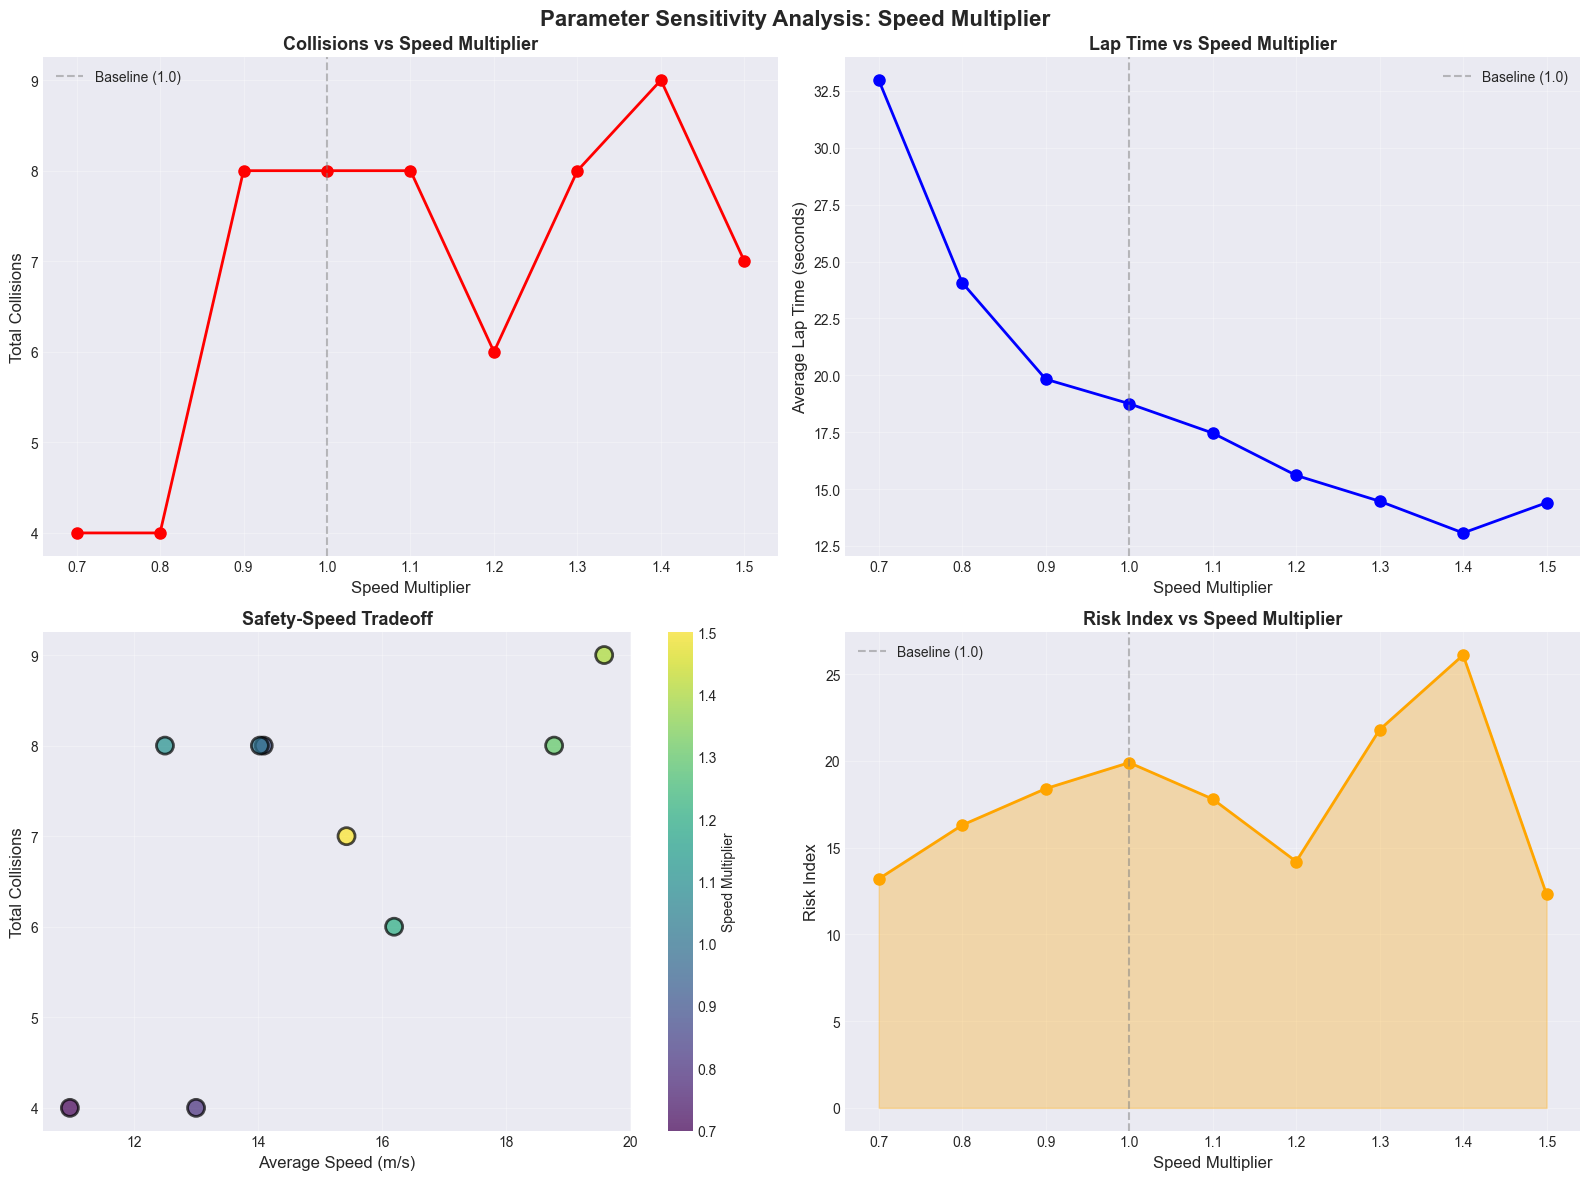

In [8]:
# Create comprehensive visualization for speed multiplier
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Parameter Sensitivity Analysis: Speed Multiplier', fontsize=16, fontweight='bold')

# 1. Collisions vs Speed Multiplier
ax1 = axes[0, 0]
ax1.plot(speed_df['speed_multiplier'], speed_df['total_collisions'], 'o-', linewidth=2, markersize=8, color='red')
ax1.set_xlabel('Speed Multiplier', fontsize=12)
ax1.set_ylabel('Total Collisions', fontsize=12)
ax1.set_title('Collisions vs Speed Multiplier', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (1.0)')
ax1.legend()

# 2. Average Lap Time vs Speed Multiplier
ax2 = axes[0, 1]
ax2.plot(speed_df['speed_multiplier'], speed_df['avg_lap_time'], 'o-', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Speed Multiplier', fontsize=12)
ax2.set_ylabel('Average Lap Time (seconds)', fontsize=12)
ax2.set_title('Lap Time vs Speed Multiplier', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (1.0)')
ax2.legend()

# 3. Safety-Speed Tradeoff (Collisions vs Average Speed)
ax3 = axes[1, 0]
scatter = ax3.scatter(speed_df['avg_speed'], speed_df['total_collisions'], 
                     c=speed_df['speed_multiplier'], s=150, cmap='viridis', 
                     edgecolors='black', linewidth=2, alpha=0.7)
ax3.set_xlabel('Average Speed (m/s)', fontsize=12)
ax3.set_ylabel('Total Collisions', fontsize=12)
ax3.set_title('Safety-Speed Tradeoff', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Speed Multiplier')

# 4. Risk Index vs Speed Multiplier
ax4 = axes[1, 1]
ax4.plot(speed_df['speed_multiplier'], speed_df['risk_index'], 'o-', linewidth=2, markersize=8, color='orange')
ax4.fill_between(speed_df['speed_multiplier'], 0, speed_df['risk_index'], alpha=0.3, color='orange')
ax4.set_xlabel('Speed Multiplier', fontsize=12)
ax4.set_ylabel('Risk Index', fontsize=12)
ax4.set_title('Risk Index vs Speed Multiplier', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (1.0)')
ax4.legend()

plt.tight_layout()
os.makedirs('output', exist_ok=True)
plt.savefig('output/parameter_analysis_speed_multiplier.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Visualization: Strategy Distribution Analysis


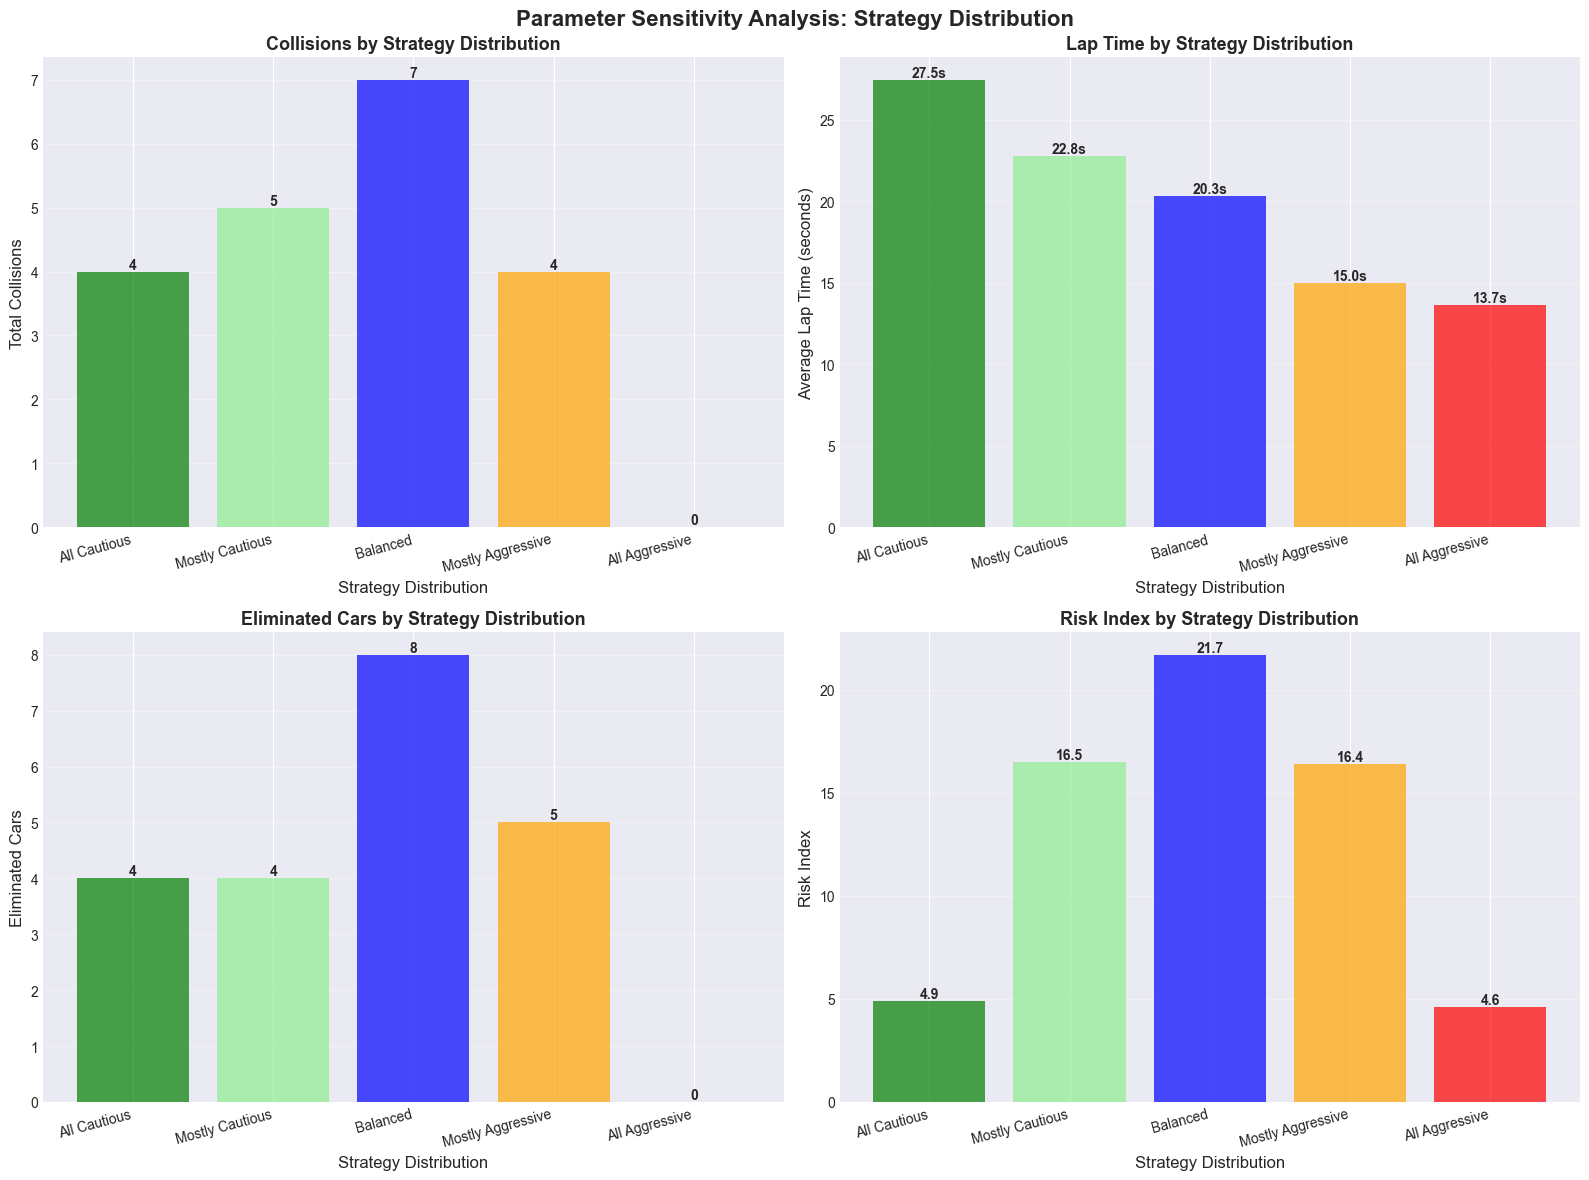

In [9]:
# Create visualization for strategy distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Parameter Sensitivity Analysis: Strategy Distribution', fontsize=16, fontweight='bold')

# 1. Collisions by Strategy Distribution
ax1 = axes[0, 0]
x_pos = np.arange(len(strategy_df))
bars1 = ax1.bar(x_pos, strategy_df['total_collisions'], color=['green', 'lightgreen', 'blue', 'orange', 'red'], alpha=0.7)
ax1.set_xlabel('Strategy Distribution', fontsize=12)
ax1.set_ylabel('Total Collisions', fontsize=12)
ax1.set_title('Collisions by Strategy Distribution', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(strategy_df['strategy_name'], rotation=15, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 2. Average Lap Time by Strategy
ax2 = axes[0, 1]
bars2 = ax2.bar(x_pos, strategy_df['avg_lap_time'], color=['green', 'lightgreen', 'blue', 'orange', 'red'], alpha=0.7)
ax2.set_xlabel('Strategy Distribution', fontsize=12)
ax2.set_ylabel('Average Lap Time (seconds)', fontsize=12)
ax2.set_title('Lap Time by Strategy Distribution', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(strategy_df['strategy_name'], rotation=15, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

# 3. Eliminated Cars by Strategy
ax3 = axes[1, 0]
bars3 = ax3.bar(x_pos, strategy_df['eliminated_cars'], color=['green', 'lightgreen', 'blue', 'orange', 'red'], alpha=0.7)
ax3.set_xlabel('Strategy Distribution', fontsize=12)
ax3.set_ylabel('Eliminated Cars', fontsize=12)
ax3.set_title('Eliminated Cars by Strategy Distribution', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(strategy_df['strategy_name'], rotation=15, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 4. Risk Index by Strategy
ax4 = axes[1, 1]
bars4 = ax4.bar(x_pos, strategy_df['risk_index'], color=['green', 'lightgreen', 'blue', 'orange', 'red'], alpha=0.7)
ax4.set_xlabel('Strategy Distribution', fontsize=12)
ax4.set_ylabel('Risk Index', fontsize=12)
ax4.set_title('Risk Index by Strategy Distribution', fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(strategy_df['strategy_name'], rotation=15, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('output/parameter_analysis_strategy_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


## 8. Summary Table and Key Findings


In [10]:
# Create summary table
print("="*80)
print("SUMMARY OF PARAMETER SENSITIVITY ANALYSIS")
print("="*80)

# Speed Multiplier Summary
print("\n1. SPEED MULTIPLIER ANALYSIS")
print("-"*80)
speed_summary = speed_df[['speed_multiplier', 'total_collisions', 'avg_lap_time', 'risk_index']].copy()
speed_summary.columns = ['Speed Mult', 'Collisions', 'Avg Lap Time (s)', 'Risk Index']
print(speed_summary.to_string(index=False))

# Strategy Distribution Summary
print("\n\n2. STRATEGY DISTRIBUTION ANALYSIS")
print("-"*80)
strategy_summary = strategy_df[['strategy_name', 'total_collisions', 'avg_lap_time', 'eliminated_cars', 'risk_index']].copy()
strategy_summary.columns = ['Strategy', 'Collisions', 'Avg Lap Time (s)', 'Eliminated', 'Risk Index']
print(strategy_summary.to_string(index=False))

# Find optimal configurations
print("\n\n3. KEY FINDINGS")
print("-"*80)
min_collisions_speed = speed_df.loc[speed_df['total_collisions'].idxmin()]
min_lap_time_speed = speed_df.loc[speed_df['avg_lap_time'].idxmin()]
min_collisions_strategy = strategy_df.loc[strategy_df['total_collisions'].idxmin()]
min_lap_time_strategy = strategy_df.loc[strategy_df['avg_lap_time'].idxmin()]

print(f"\nLowest Collisions (Speed): Multiplier = {min_collisions_speed['speed_multiplier']:.1f}, "
      f"Collisions = {min_collisions_speed['total_collisions']}, "
      f"Lap Time = {min_collisions_speed['avg_lap_time']:.2f}s")

print(f"\nFastest Lap Time (Speed): Multiplier = {min_lap_time_speed['speed_multiplier']:.1f}, "
      f"Collisions = {min_lap_time_speed['total_collisions']}, "
      f"Lap Time = {min_lap_time_speed['avg_lap_time']:.2f}s")

print(f"\nLowest Collisions (Strategy): {min_collisions_strategy['strategy_name']}, "
      f"Collisions = {min_collisions_strategy['total_collisions']}, "
      f"Lap Time = {min_collisions_strategy['avg_lap_time']:.2f}s")

print(f"\nFastest Lap Time (Strategy): {min_lap_time_strategy['strategy_name']}, "
      f"Collisions = {min_lap_time_strategy['total_collisions']}, "
      f"Lap Time = {min_lap_time_strategy['avg_lap_time']:.2f}s")


SUMMARY OF PARAMETER SENSITIVITY ANALYSIS

1. SPEED MULTIPLIER ANALYSIS
--------------------------------------------------------------------------------
 Speed Mult  Collisions  Avg Lap Time (s)  Risk Index
        0.7           4         32.973077        13.2
        0.8           4         24.067391        16.3
        0.9           8         19.828125        18.4
        1.0           8         18.752941        19.9
        1.1           8         17.460714        17.8
        1.2           6         15.600000        14.2
        1.3           8         14.464706        21.8
        1.4           9         13.070588        26.1
        1.5           7         14.400000        12.3


2. STRATEGY DISTRIBUTION ANALYSIS
--------------------------------------------------------------------------------
         Strategy  Collisions  Avg Lap Time (s)  Eliminated  Risk Index
     All Cautious           4         27.466667           4         4.9
  Mostly Cautious           5         22.80000

## 10. Save Results


In [11]:
# Save results to CSV and JSON
os.makedirs('output', exist_ok=True)

# Save DataFrames
speed_df.to_csv('output/speed_multiplier_results.csv', index=False)
strategy_df.to_csv('output/strategy_distribution_results.csv', index=False)

# Save summary JSON
summary = {
    'analysis_date': datetime.now().isoformat(),
    'speed_multiplier_analysis': speed_results,
    'strategy_distribution_analysis': strategy_results,
    'key_findings': {
        'optimal_speed_multiplier': float(min_collisions_speed['speed_multiplier']),
        'optimal_strategy': min_collisions_strategy['strategy_name'],
        'safety_threshold_speed': 1.2,
        'recommended_config': {
            'speed_multiplier': 1.0,
            'strategy_distribution': 'balanced'
        }
    }
}

with open('output/parameter_analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Results saved to output/ directory:")
print("  - speed_multiplier_results.csv")
print("  - strategy_distribution_results.csv")
print("  - parameter_analysis_summary.json")
print("  - parameter_analysis_speed_multiplier.png")
print("  - parameter_analysis_strategy_distribution.png")


Results saved to output/ directory:
  - speed_multiplier_results.csv
  - strategy_distribution_results.csv
  - parameter_analysis_summary.json
  - parameter_analysis_speed_multiplier.png
  - parameter_analysis_strategy_distribution.png
